In [ ]:
from pathlib import Path
import pylatexenc

# path to wherever Jupyter is launched from
project_root = Path.cwd()  

# now build a path to .qasm files
qasm_dir   = project_root / "assets" / "baseline" #r"\Student\Desktop\Hackathon\Qasm files"
qasm_file_paths = sorted(qasm_dir.glob("*.qasm"))


if not qasm_file_paths:
    raise FileNotFoundError(f"No .qasm files found in {qasm_dir}")

In [ ]:
from bloqade import qasm2
from bloqade.qasm2.parse.lowering import QASM2
from bloqade.qasm2.passes import QASM2Py

# parse & lower each one
programs = {}
for path in qasm_file_paths:
    prog = QASM2(qasm2.main).loadfile(file=path)

    """
    reinterpret into Bloqade's parallelization-friendly intermediate representation. 
    Similar behaviour could have been obtained by just using qasm2.extended above
    """
    QASM2Py(prog.dialects)(prog)
    prog_extended = prog.similar(qasm2.extended)

    programs[Path(path).stem] = prog
    prog_extended = prog
    print(f"→ {path} parsed & lowered: {prog}")

# `programs` now holds each file’s lowered IR under its filename-stem.

→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/0.1.qasm parsed & lowered: Method("0.1")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/0.2.qasm parsed & lowered: Method("0.2")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/0.4.qasm parsed & lowered: Method("0.4")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/1.qasm parsed & lowered: Method("1")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/2.qasm parsed & lowered: Method("2")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/3.qasm parsed & lowered: Method("3")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/4.qasm parsed & lowered: Method("4")


In [ ]:
import qiskit
from kirin import ir
from qiskit import QuantumCircuit

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold


@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass


# helper to go from Method → Qiskit
def method_to_qiskit(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # run extended pass in case forgot
    # extended_opt.run_pass(method, parallelize=parallelize)
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

In [ ]:
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer


def write_to_qasm_file(circuit, filename):
    with open(filename, "w") as f:
        qasm_object = QASM2()
        qasm_string = qasm_object.emit_str(circuit)
        f.write(qasm_string)

        
target = QASM2(allow_parallel=True)

In [ ]:
challenge = "1"
program_ast = target.emit(programs[challenge])
pprint(program_ast)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[3];
h var_0[2];
CX var_0[1], var_0[2];
U(0.0, (3.141592653589793 * 1.25), (3.141592653589793 * 0.5)) var_0[2];
CX var_0[1], var_0[2];
U(0.0, (3.141592653589793 * 1.75), (3.141592653589793 * 0.5)) var_0[2];
CX var_0[0], var_0[2];
U(0.0, (3.141592653589793 * 1.375), (3.141592653589793 * 0.5)) var_0[2];
CX var_0[0], var_0[2];
U(0.0, (3.141592653589793 * 1.625), (3.141592653589793 * 0.5)) var_0[2];
h var_0[1];
CX var_0[0], var_0[1];
U(0.0, (3.141592653589793 * 1.25), (3.141592653589793 * 0.5)) var_0[1];
CX var_0[0], var_0[1];
U(0.0, (3.141592653589793 * 1.75), (3.141592653589793 * 0.5)) var_0[1];
h var_0[0];


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk


circuit = programs[challenge]

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[3];
h var_0[2];
CX var_0[1], var_0[2];
U(0.0, (3.141592653589793 * 1.25), (3.141592653589793 * 0.5)) var_0[2];
CX var_0[1], var_0[2];
U(0.0, (3.141592653589793 * 1.75), (3.141592653589793 * 0.5)) var_0[2];
CX var_0[0], var_0[2];
U(0.0, (3.141592653589793 * 1.375), (3.141592653589793 * 0.5)) var_0[2];
CX var_0[0], var_0[2];
U(0.0, (3.141592653589793 * 1.625), (3.141592653589793 * 0.5)) var_0[2];
h var_0[1];
CX var_0[0], var_0[1];
U(0.0, (3.141592653589793 * 1.25), (3.141592653589793 * 0.5)) var_0[1];
CX var_0[0], var_0[1];
U(0.0, (3.141592653589793 * 1.75), (3.141592653589793 * 0.5)) var_0[1];
h var_0[0];


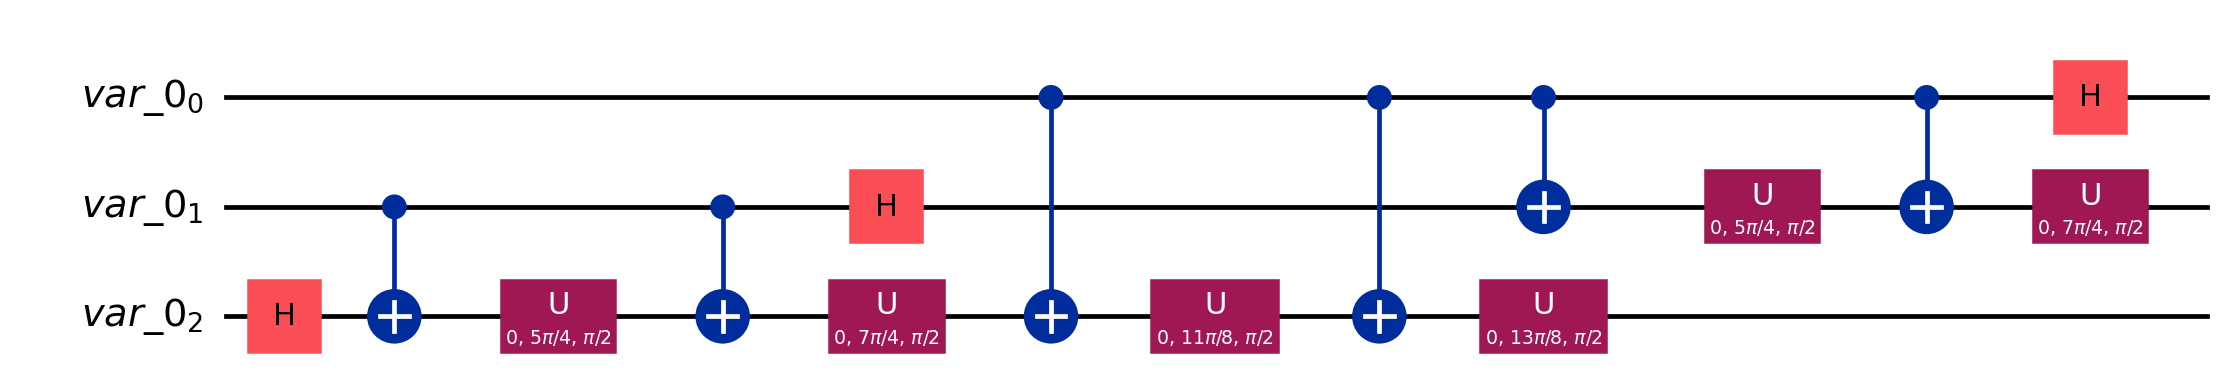

In [ ]:
native_gates_unoptimized_ast = target.emit(circuit)
pprint(native_gates_unoptimized_ast)
qc = method_to_qiskit(circuit)
#print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=1.7)
display(fig)   # in a Jupyter notebook

## Starts again but now overwrites circuit with parallelisation

In [ ]:
from bloqade import qasm2
from bloqade.qasm2.parse.lowering import QASM2
from bloqade.qasm2.passes import QASM2Py

# parse & lower each one
programs = {}
for path in qasm_file_paths:
    prog = QASM2(qasm2.main).loadfile(file=path)

    """
    reinterpret into Bloqade's parallelization-friendly intermediate representation. 
    Similar behaviour could have been obtained by just using qasm2.extended above
    """
    QASM2Py(prog.dialects)(prog)
    prog = prog.similar(qasm2.extended)

    programs[Path(path).stem] = prog
    print(f"→ {path} parsed & lowered: {prog}")

# `programs` now holds each file’s lowered IR under its filename-stem.


→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/0.1.qasm parsed & lowered: Method("0.1")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/0.2.qasm parsed & lowered: Method("0.2")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/0.4.qasm parsed & lowered: Method("0.4")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/1.qasm parsed & lowered: Method("1")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/2.qasm parsed & lowered: Method("2")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/3.qasm parsed & lowered: Method("3")
→ /home/carlfre/hackathons/eth_hackathon/assets/baseline/4.qasm parsed & lowered: Method("4")


For the above, we need to use the `loadfile()` method to read text from a file into a Bloqade program. If instead you want to read a QASM circuit that is already stored in a variable in your code as a string, use `loads()` as a method.

Now we choose the target Bloqade dialect group that will be interpreting and compiling circuits to. Since we will be seeking parallelization of our circuits throughout, we enable that as follows

In [ ]:
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

target = QASM2(allow_parallel=True)

We are ready! Let's look at a QASM file of one of the programs we loaded.

Note that `target.emit` produces an AST [Abstract Syntax Tree](https://en.wikipedia.org/wiki/Abstract_syntax_tree) that can be used for pretty printing but if you just want a standard QASM2 string to work with, you can use the `emit_str` method instead (: 

In [ ]:
program_ast = target.emit(programs[challenge])
pprint(program_ast)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[3];
h var_0[2];
CX var_0[1], var_0[2];
U(0.0, 3.9269908169872414, 1.5707963267948966) var_0[2];
CX var_0[1], var_0[2];
U(0.0, 5.497787143782138, 1.5707963267948966) var_0[2];
CX var_0[0], var_0[2];
U(0.0, 4.319689898685965, 1.5707963267948966) var_0[2];
CX var_0[0], var_0[2];
U(0.0, 5.105088062083414, 1.5707963267948966) var_0[2];
h var_0[1];
CX var_0[0], var_0[1];
U(0.0, 3.9269908169872414, 1.5707963267948966) var_0[1];
CX var_0[0], var_0[1];
U(0.0, 5.497787143782138, 1.5707963267948966) var_0[1];
h var_0[0];


These circuits are not ready for neutral-atom implementations. The native gates are not correct, and we don't see any parallelization of compatible unitaries. Let's revisit that then.

If we were careful (we were!) to interpret our circuits with `qasm2.extended`, we can use our Kirin compiler tool chain to "walk" through the circuit and apply gate rewrites into our neutral-atom native set following correct rewrite rules. That is achieved as follows (dismiss warnings, if they appear!)

In [ ]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk


circuit = programs[challenge]

Walk(RydbergGateSetRewriteRule(circuit.dialects)).rewrite(circuit.code);

In [ ]:



write_to_qasm_file(circuit, "storage/tempcirc.qasm")

In [ ]:
# print(dir(circuit))

['_Printable__get_printer', '__annotations__', '__call__', '__class__', '__class_getitem__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'arg_names', 'arg_types', 'args', 'callable_region', 'code', 'dialects', 'fields', 'file', 'inferred', 'lineno_begin', 'mod', 'pager', 'print', 'print_impl', 'print_str', 'py_func', 'return_type', 'self_type', 'similar', 'sym_name', 'verify', 'verify_type']


Transformations on the circuit happen in place (because we didn't use `similar()` to generate a new circuit). Let's see what happened

In [ ]:
native_gates_unoptimized_ast = target.emit(circuit)
pprint(native_gates_unoptimized_ast)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[3];
U(1.5707963267949, 0.0, 3.14159265358979) var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
cz var_0[1], var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
U(0.0, 0.0, 3.14159265358979) var_0[1];
U(0.0, 0.0, 6.28318530717958) var_0[2];
U(0.0, 3.9269908169872414, 1.5707963267948966) var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
cz var_0[1], var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
U(0.0, 0.0, 3.14159265358979) var_0[1];
U(0.0, 0.0, 6.28318530717958) var_0[2];
U(0.0, 5.497787143782138, 1.5707963267948966) var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
cz var_0[0], var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
U(0.0, 0.0, 3.14159265358979) var_0[0];
U(0.0, 0.0, 6.28318530717958) var_0[2];
U(0.0, 4.319689898685

All the CNOTs and Hadamards were converted accordingly to CZs and $R_y(\pi/2)$ rotations. This is the gate-set that we want!

The process above was a compiler pass and we are not done with them. Now we want to generate parallel commands. We can do that via another pass as follows

In [ ]:
from bloqade.qasm2.passes import UOpToParallel

UOpToParallel(circuit.dialects)(circuit)
parallelized_circuit = circuit.similar(qasm2.extended)

Now circuit got modified, but we created a copy of it and saved in `circuit_parallel` for the sake of example. Let's see what we got

In [ ]:
native_gates_optimized_ast = target.emit(parallelized_circuit)
pprint(native_gates_optimized_ast)

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg var_0[3];
U(1.5707963267949, 0.0, 3.14159265358979) var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
cz var_0[1], var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
U(0.0, 3.9269908169872414, 1.5707963267948966) var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
cz var_0[1], var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
U(0.0, 5.497787143782138, 1.5707963267948966) var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
cz var_0[0], var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
U(0.0, 4.319689898685965, 1.5707963267948966) var_0[2];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) var_0[2];
cz var_0[0], var_0[2];
U(1.5707963267949, 0.0, 6.28318530717959) var_0[2];
U(0.0, 5.105088062083414, 1.5707963267948966) var_0[2];
U(1.57079

Now we got a circuit that can be interpreted by a neutral-atom quantum computer with the understanding of what operations can (and should!) be done in parallel.

## Parallelization performance analysis

How well did we do? Let's count our parallel operations! Some of our operations are parallelizable, but others are not. Counting them in separate can be promptly achieved from the QASM file as follows

In [ ]:
# Put the code below into a function that accepts an AST
# and prints the counts 

def print_gate_counts(ast): 
    """
    Print the counts of parallel and non parallel in the given AST,
    Distinguishing between single U and CZ gates and their parallelized versions.
    """
    test_string = qasm2.parse.spprint(ast)

    parallel_cz_count = test_string.count("parallel.CZ")
    parallel_u_count = test_string.count("parallel.U")
    u_count = test_string.count("U")  # To avoid counting "parallel.U"
    cz_count = test_string.count("cz")

    print(f"parallel CZ: {parallel_cz_count}")
    print(f"parallel U: {parallel_u_count}")
    print(f"other U: {u_count - parallel_u_count}")
    print(f"other CZ: {cz_count}")

In [ ]:
# Lets plug in the AST we got from translating the QAOA circuit 
# to the native gate set but with no optimizations

print("Unoptimized Circuit with Native Gates")
print_gate_counts(native_gates_unoptimized_ast)

print("\n")

# Now lets plug in the AST we got after parallelization

print("Optimized Circuit with Native Gates")
print_gate_counts(native_gates_optimized_ast)

Unoptimized Circuit with Native Gates


parallel CZ: 0
parallel U: 0
other U: 21
other CZ: 6


Optimized Circuit with Native Gates
parallel CZ: 0
parallel U: 0
other U: 21
other CZ: 6


But if you want to operate directly from a Bloqade program, a circuit will have a `callable_region` that can be "walked" and examined for the gates that appear in them. Then, we can extract our counts as

In [ ]:
parallel_cz = 0
standard_cz = 0
parallel_u = 0
other_u = 0
for stmt in parallelized_circuit.callable_region.walk():
    
    if isinstance(stmt, qasm2.dialects.parallel.CZ):
        parallel_cz += 1
    elif isinstance(stmt, qasm2.dialects.uop.CZ):
        standard_cz += 1
    elif isinstance(stmt, (qasm2.dialects.parallel.UGate, qasm2.dialects.parallel.RZ)):
        parallel_u += 1
    elif isinstance(stmt, (qasm2.dialects.uop.SingleQubitGate)):
        other_u += 1
    #else: print(stmt)
        
print(f"parallel CZ: {parallel_cz}")
print(f"parallel U: {parallel_u}")
print(f"Other U: {other_u}")
print(f"other CZ: {standard_cz}")

parallel CZ: 0
parallel U: 0
Other U: 21
other CZ: 6


## Visualization

Ok, looking at QASM can be a bit tiring. While Bloqade shines in allowing you to optimize programs for neutral atom architectures as well as build complex circuits easily, we are still working on visualization functionalities. While that is not ready, we can always use other packages to help! For example, if you like Qiskit, we can define a simple method to generate a Qiskit circuit from our new circuits. 

First let's just define a compiler pass that combines all the process above; then we ensure that every circuit exported to Qiskit will be recompiled in advance. Here we go.

In [ ]:
from kirin import ir
from qiskit import QuantumCircuit

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold


@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass


# helper to go from Method → Qiskit
def method_to_qiskit(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # run extended pass in case forgot
    extended_opt.run_pass(method, parallelize=parallelize)
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)


Let's see this in action

                                                                        »
var_0_0: ───────────────────────────────────────────────────────────────»
                                                                        »
var_0_1: ─────────────────────────────■─────────────────────────────────»
         ┌────────────┐┌────────────┐ │ ┌─────────────┐┌───────────────┐»
var_0_2: ┤ U(π/2,0,π) ├┤ U(π/2,π,π) ├─■─┤ U(π/2,0,2π) ├┤ U(0,5π/4,π/2) ├»
         └────────────┘└────────────┘   └─────────────┘└───────────────┘»
«                                                                           »
«var_0_0: ────────────────────────────────────────────────────────────────■─»
«                           ┌────────────┐  ┌────────────┐                │ »
«var_0_1: ───────────────■──┤ U(π/2,0,π) ├──┤ U(π/2,π,π) ├────────────────┼─»
«         ┌────────────┐ │ ┌┴────────────┤┌─┴────────────┴┐┌────────────┐ │ »
«var_0_2: ┤ U(π/2,π,π) ├─■─┤ U(π/2,0,2π) ├┤ U(0,7π/4,π/2) ├┤ U(π/2,π,π) ├─■─»
«         └───

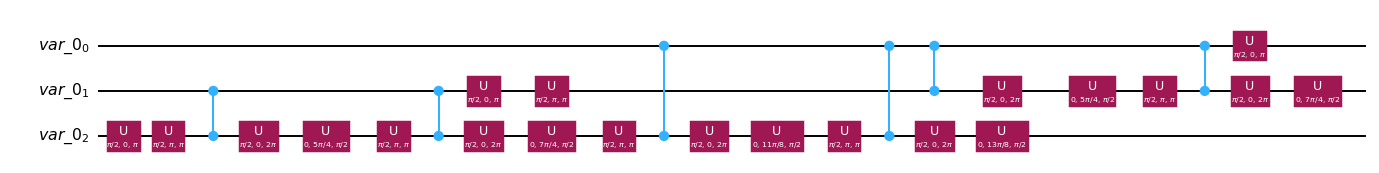

In [ ]:
qc = method_to_qiskit(parallelized_circuit)

print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=0.7)
display(fig)   # in a Jupyter notebook

When producing images automatically, we lose a bit the handles of the barriers that define parallelizable operations. Still, for simple circuits, these can still be inspected by eye, helping optimization.

# We will now reduce the ciruit!!!

Code for multiplying U3 matrices.

In [ ]:
import numpy as np

from scipy.optimize import minimize


def U3(
    theta: float,
    phi: float,
    lamb: float,
) -> np.ndarray:
    return np.array(
        [
            [np.exp(-1j * (phi + lamb)/2) * np.cos(theta / 2), -np.exp(- 1j * (phi - lamb)/2) * np.sin(theta / 2)],
            [np.exp(1j * (phi - lamb)/2 ) * np.sin(theta / 2), np.exp(1j * (phi + lamb)/ 2) * (np.cos(theta / 2)),],
        ]
    )


def prod_U3s(
    theta: float,
    phi: float,
    lamb: float,
    thetaprime: float,
    phistar: float,
    lambstar: float,
    debug: bool = False,
) -> tuple[float, float, float, float]:

    U = U3(theta, phi, lamb)
    Uprime = U3(thetaprime, phistar, lambstar)
    U_prod_true = U @ Uprime

    alpha_start, beta_start, gamma_start = np.random.rand(3) * 2 * np.pi

    def objective(params):
        Uprod_estimate = U3(params[0], params[1], params[2])
        return np.linalg.norm(U_prod_true - Uprod_estimate)
    
    res = minimize(
        objective,
        [alpha_start, beta_start, gamma_start],
        method="BFGS",
        tol=1e-8,
        options={"maxiter": 10000}

    )
    alpha, beta, gamma = res.x
    if debug:
        print(res)

    return alpha, beta, gamma, res.fun

Now, let's actually apply the simplification

In [ ]:
from bloqade.qasm2.emit import QASM2 as QASM2_target # the QASM2 target
from bloqade.qasm2.parse.lowering import QASM2

from bloqade import qasm2
import numpy as np

path=  "storage/tempcirc.qasm"


In [ ]:
np.random.seed(0)


def merge(segment):
    seg = segment.copy()[::-1]
    # print(segment)
    params = seg[-1][2]
    for i in range(len(seg) -2, -1, -1):
        alpha, beta, gamma, _ = map(float, prod_U3s(*seg[i][2], *params))
        params = (alpha, beta, gamma)
    
    # print(params)
    # raise ValueError("STOP")

    return params





with open(path, "r") as f:
    original_lines = f.readlines()
    lines = [line.strip().replace(",", "").replace(";", "") for line in original_lines.copy()]
    lines = lines[3:]

    qubits = set()
    # for line in lines:

    for line in lines:
        elements = line.split()
        if len(elements) == 4:
            qubits.add(elements[-1])

    # print(qubits)

    # print(lines)
    what_to_do_with_lines = ["keep"] * len(lines)
    for qubit in qubits:
        gate_applications = []
        for i, line in enumerate(lines):
            if qubit in line:
                elements = line.split()
                # print(elements[0])
                if elements[0].startswith("U("):
                    theta = float(elements[0].split("(")[1])
                    phi = float(elements[1])
                    lam = float(elements[2].split(")")[0])
                    # params = [float(x.replace("(", "").replace(")", "")) for x in elements]
                    gate_applications.append((i, "U", (theta, phi, lam)))
                elif elements[0] == "cz":
                    gate_applications.append((i, "cz", -1))
                else:
                    raise ValueError(f"Unknown gate type: {elements[0]}")
                

        segment = []

        for i in range(len(gate_applications)):
            if gate_applications[i][1] == "U":
                segment.append(gate_applications[i])
            elif gate_applications[i][1] == "cz":
                if len(segment) > 1:
                    new_params = merge(segment)
                    what_to_do_with_lines[segment[0][0]] = ("replace", new_params)
                    for j in range(1, len(segment)):
                        what_to_do_with_lines[segment[j][0]] = "remove"
                segment = []

        if len(segment) > 1:
            new_params = merge(segment)
            what_to_do_with_lines[segment[0][0]] = ("replace", new_params)
            for j in range(1, len(segment)):
                what_to_do_with_lines[segment[j][0]] = "remove"

            
        
        # print(*gate_applications, sep="\n")
# print("WHAT TO DO WITH LINES")
# print(*what_to_do_with_lines, sep="\n")

# print(lines[-1])

new_lines = original_lines[3:]
# print(new_lines)
# print(*what_to_do_with_lines, sep="\n")

print(what_to_do_with_lines)

for i in range(len(what_to_do_with_lines)):
    if isinstance(what_to_do_with_lines[i], tuple):
        print(what_to_do_with_lines[i])
        if what_to_do_with_lines[i][0] == "replace":
            print("hey")
            new_lines[i] = f"U({what_to_do_with_lines[i][1][0]}, {what_to_do_with_lines[i][1][1]}, {what_to_do_with_lines[i][1][2]}) {lines[i].split()[-1]};\n"
            print(what_to_do_with_lines[i])
            print(new_lines[i])
        else:
            raise ValueError(f"Unknown action: {what_to_do_with_lines[i][0]}")
print(new_lines)
new_lines = [line for i, line in enumerate(new_lines) if what_to_do_with_lines[i] != "remove"]
new_lines = original_lines[:3] + new_lines
print(new_lines)

program = "".join(new_lines)



with open("storage/result_circuit.qasm", "w") as f:
    f.write(program)
    # for i, line in enumerate(lines):

    
    

[('replace', (3.141592924764994, 5.7109079911354925, 2.569315024923469)), 'remove', 'keep', ('replace', (7.0685834747005005, 7.853981627640236, -1.570796337438145)), 'keep', 'remove', 'remove', 'remove', 'keep', ('replace', (-0.7853981560922453, 1.5707963068578958, 10.995574283069885)), ('replace', (3.1415934195503903, 2.5019699277751313, 2.5019698567485427)), 'remove', 'remove', 'remove', 'keep', ('replace', (5.890486209343438, 4.712388983028415, 1.5707963067592896)), 'keep', 'remove', 'remove', 'remove', 'keep', ('replace', (4.712388991597563, 0.39269907517876396, -5.611934289901784e-09)), 'keep', 'remove', 'remove', 'remove', 'remove', 'keep', ('replace', (5.497787149080817, 4.712388978246653, 1.570796318070194)), 'keep', 'remove', 'remove', 'remove', 'keep', ('replace', (1.5707963284183435, 3.9269908116154246, 3.1415926359192214)), ('replace', (-1.5707963321226752, 3.141592650448059, 3.1415926459870493)), 'remove', 'remove', 'remove']
('replace', (3.141592924764994, 5.7109079911354

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np

with open ("assets/baseline/1.qasm", "r") as f:
    baseline = f.read()

with open("storage/tempcirc.qasm", "r") as f:
    unshortened = f.read()

qiskit_circuit = QuantumCircuit.from_qasm_str(program)
qiskit_circuit_baseline = QuantumCircuit.from_qasm_str(baseline)
qiskit_circuit_unshortened = QuantumCircuit.from_qasm_str(unshortened)


oper = Operator(qiskit_circuit)
oper_baseline = Operator(qiskit_circuit_baseline)
oper_unshortened = Operator(qiskit_circuit_unshortened)


print(np.linalg.norm(oper_baseline - np.exp(1j * 2) * oper))

4.367956002754722


In [ ]:
min_norm = np.inf
for phi in np.linspace(0, 2*np.pi, 1000000):

    min_norm = min(np.linalg.norm(oper - np.exp(1j * phi) * oper_baseline), min_norm)

print(min_norm)

# phi = 0
# print(np.linalg.norm(oper - np.exp(1j * phi) * oper_baseline))

5.86268913927347e-06


In [ ]:
print(np.allclose(oper_baseline, oper_unshortened))

True


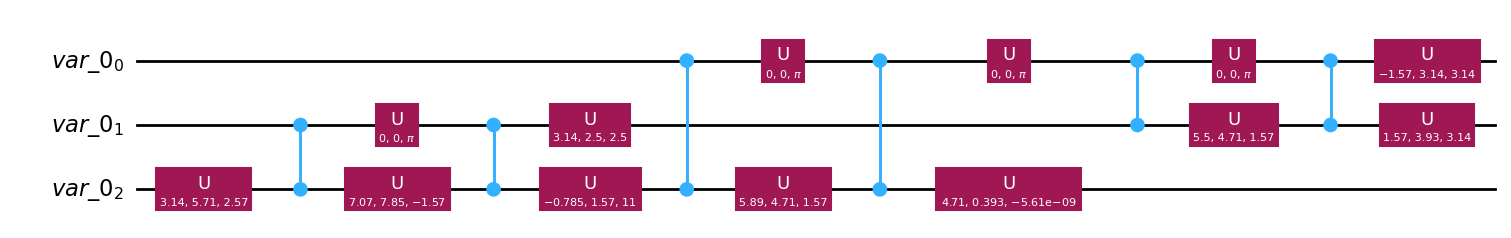

In [ ]:
qiskit_circuit.draw(output="mpl")

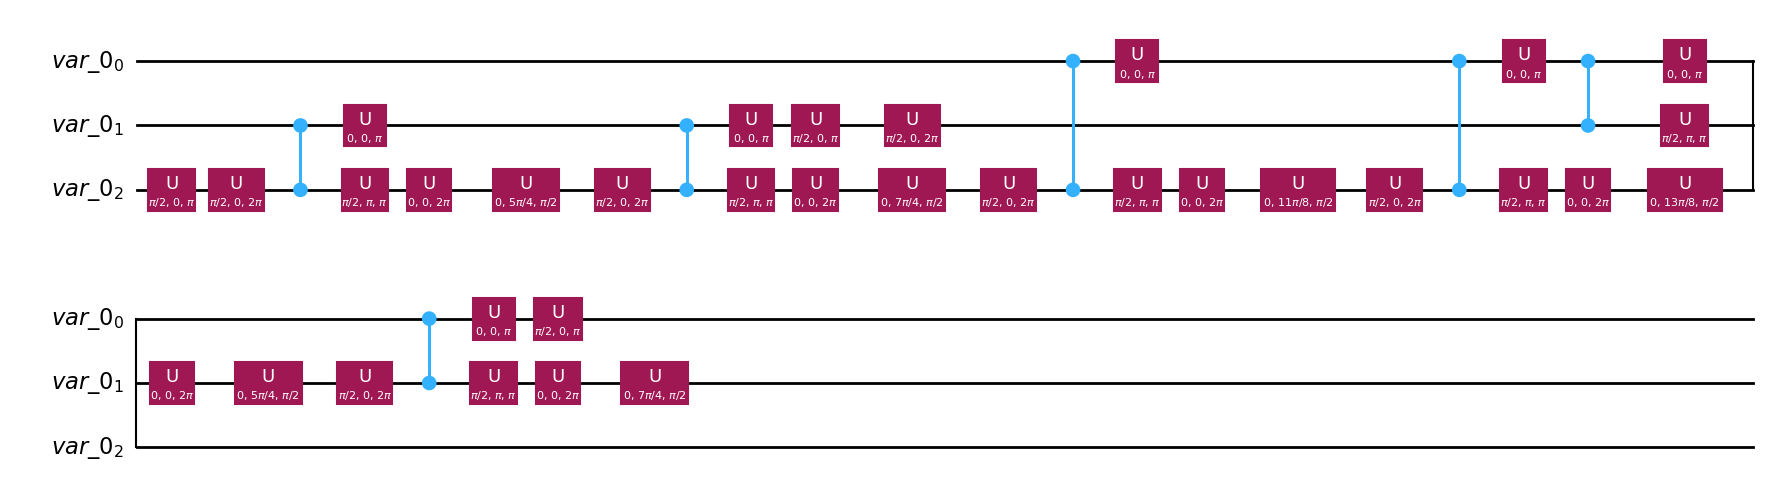

In [ ]:
qiskit_circuit_unshortened.draw(output="mpl")

In [ ]:
from qiskit.circuit.library import UGate


ggate = UGate(0.5, 0.5, 0.5)
print(ggate.to_matrix())

[[ 0.96891242+0.j         -0.2171174 -0.11861178j]
 [ 0.2171174 +0.11861178j  0.52350562+0.81531169j]]


In [ ]:
print(oper - oper_unshortened)

Operator([[-0.35355339+4.17228019e-15j, -0.13529903+3.26640741e-01j,
            0.45710678+2.50000000e-01j,  0.13529903+3.26640741e-01j,
           -0.35355339+1.18910452e-15j, -0.13529903+3.26640741e-01j,
           -0.95710678+2.50000000e-01j,  0.13529903+3.26640741e-01j],
          [-0.35355339+6.45700524e-15j,  0.84240581-3.26640741e-01j,
           -0.25      +2.50000000e-01j, -0.13529903-3.26640741e-01j,
           -0.35355339+3.47382956e-15j, -0.57180776-3.26640741e-01j,
           -0.25      +2.50000000e-01j, -0.13529903-3.26640741e-01j],
          [ 0.35355339-2.56069383e-15j, -0.32664074-1.35299025e-01j,
            0.25      -2.50000000e-01j,  0.32664074-1.35299025e-01j,
            0.35355339-7.90709917e-15j, -0.32664074-1.35299025e-01j,
            0.25      -2.50000000e-01j,  0.32664074-1.35299025e-01j],
          [-0.35355339+1.11476565e-14j,  0.32664074+1.35299025e-01j,
            0.25      -2.50000000e-01j,  0.38046604+1.35299025e-01j,
           -0.35355339+8.085976